In [6]:
import jax
import distrax
import seaborn as sns
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from rebayes_mini.methods.gauss_filter import GaussianFilter
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [7]:
%config InlineBackend.figure_format = "retina"
plt.rc("text", usetex=True)
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 15

In [8]:
p_change = 0.005
p_change = 0.00

def step(params, key):
    key_x, key_y, key_change, key_params = jax.random.split(key, 4)

    change = jax.random.uniform(key_change) < p_change

    key_theta0, key_theta1, key_theta2 = jax.random.split(key_params, 3)
    theta0 = jax.random.uniform(key_theta0, (1,), minval=-3, maxval=3)
    theta1 = jax.random.uniform(key_theta1, (1,), minval=-3, maxval=3)
    theta2 = jax.random.uniform(key_theta2, (1,), minval=-3, maxval=3)

    params_change = jnp.concat([theta0, theta1, theta2])
    params = params * (1 - change) + params_change * change

    x = jax.random.uniform(key_x, minval=-2, maxval=2)
    x = jnp.c_[1, x, x ** 2]

    yclean = x @ params
    y = yclean + jax.random.normal(key_y)

    out = {
        "params": params,
        "y": y,
        "x": x,
        "change": change,
        "yclean": yclean,
    }

    return params, out

In [9]:
key = jax.random.PRNGKey(314159)
key = jax.random.PRNGKey(3141)

n_samples = 300
keys = jax.random.split(key, n_samples)
theta_init = jnp.array([1.0, 1.0, 1.0])

_, hist_dpg = jax.lax.scan(step, theta_init, keys)

In [11]:
X = hist_dpg["x"].squeeze()
y = hist_dpg["y"]

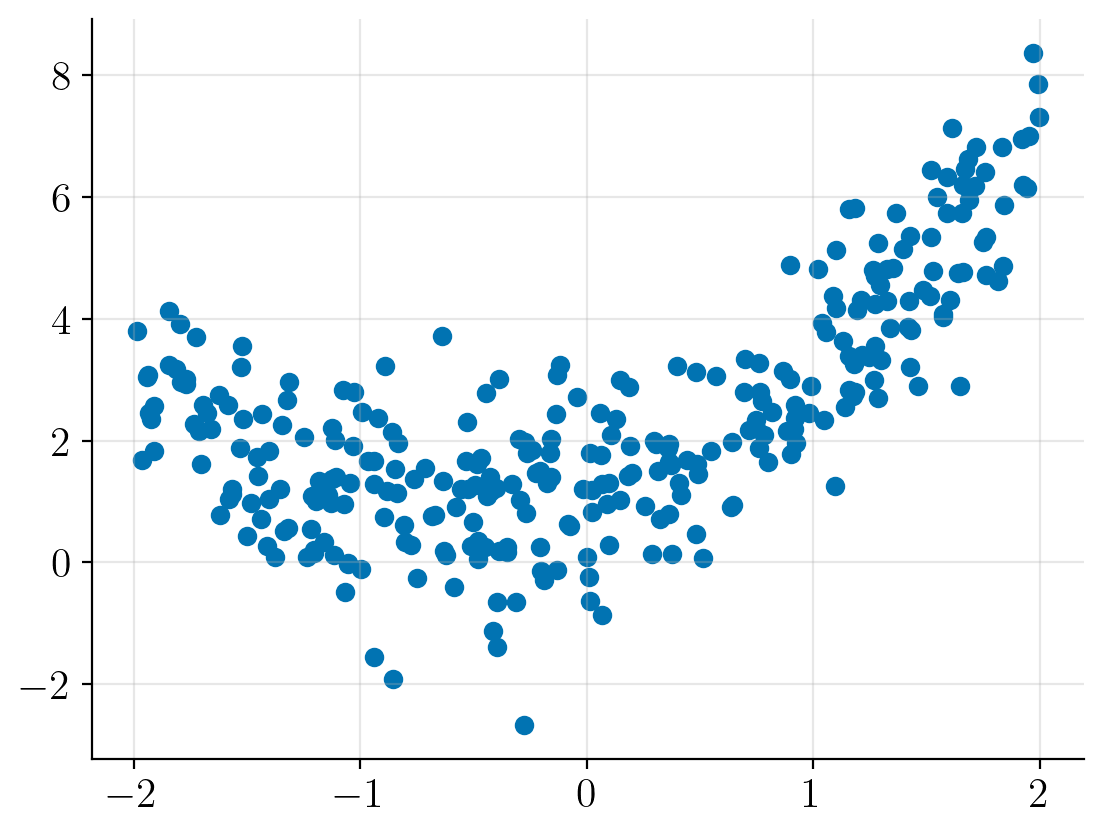

In [12]:
plt.scatter(X[:, 1], y)
plt.grid(alpha=0.3)

## Problem formulation

Observation model
$$
    p(y_t \vert \boldsymbol\theta_t, {\bf x}_t) = {\cal N}(y_t \vert {\bf x}_t^\intercal\boldsymbol\theta_t, \beta)
$$

with known observation precision $\tau$ and prior
$$
    p(\boldsymbol\theta_t) = {\cal N}\left(\boldsymbol\theta_t \vert \boldsymbol 0, \alpha^{-1}{\bf I}\right)
$$


### The components

**The predictive probability**

$$
\begin{aligned}
    p(\boldsymbol y_t \vert \boldsymbol\mu, \boldsymbol\Sigma, {\bf x}_t)
    &= \int p(\boldsymbol y_t, \boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma, {\bf x}_t) d\boldsymbol\theta\\
    &= \int p(\boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma)p(\boldsymbol y_t \vert \boldsymbol\theta, {\bf x}_t)d\boldsymbol\theta\\
    &= \int {\cal N}(\boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma)
    {\cal N}(\boldsymbol y_t \vert \boldsymbol\theta^\intercal {\bf x}_t, \beta^{-1})d\boldsymbol\theta\\
    &=
    {\cal N}(\boldsymbol y_t \vert \boldsymbol\mu^\intercal {\bf x}_t, \beta^{-1} + {\bf x}_t^\intercal\boldsymbol\Sigma{\bf x}_t)
\end{aligned}
$$

In [13]:
from rebayes_mini.callbacks import get_predicted_mean

In [14]:
def callback(bel, bel_prior, y, x):
    yhat = applyfn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [15]:
def applyfn(w, x):
    return jnp.atleast_1d(w @ x)

In [20]:
wprior = jnp.zeros(3)
static_agent = GaussianFilter(
    applyfn, dynamics_covariance=1e-5,
)

In [21]:
bel = static_agent.init_bel(wprior)
bel_final, hist = static_agent.scan(bel, y, X, callback)
means = hist["mean"]

In [22]:
errs = (hist["yhat"] - hist_dpg["yclean"]).ravel()

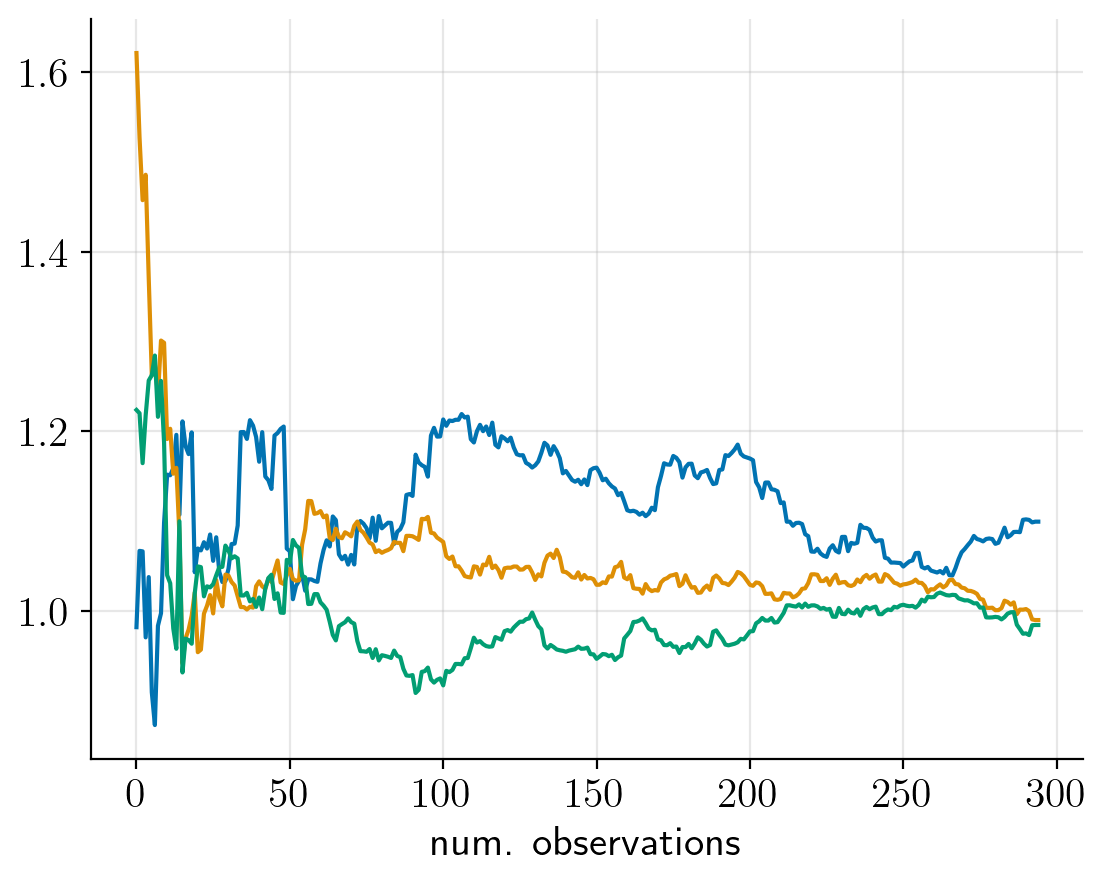

In [23]:
plt.plot(means[5:])
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

## An animation

In [24]:
X, y, errs = jax.tree.map(np.array, (X, y, errs))

In [25]:
errs = pd.Series(errs)

In [26]:
xmin, xmax = X[:, 1].min(), X[:, 1].max()
xeval = np.linspace(xmin, xmax)
xeval = np.c_[xeval ** 0, xeval ** 1, xeval ** 2]

In [27]:
from matplotlib.animation import FuncAnimation

In [28]:
def animate(t, ax):
    for axi in ax:
        axi.cla()
    print(t, end="\r")
    ax[0].set_xlim(X[:, 1].min(), X[:, 1].max())
    ax[0].scatter(X[:t, 1], y[:t])
    ax[0].grid(alpha=0.3)
    ax[0].plot(xeval[:, 1], xeval @ means[t], c="black", linewidth=2)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    np.power(errs, 2).expanding().mean()[:t].plot(ax=ax[1], c="black")
    ax[1].set_yscale("log")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, n_samples)
    ax[1].set_title("RMSE")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, n_samples))
animation.save("sequential.gif", fps=20)


KeyboardInterrupt



Error in callback <function flush_figures at 0x7f633d25c820> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



## Logistic regression

In [604]:
import einops
import flax.linen as nn
from moons_data import make_rotating_moons
from rebayes_mini.methods.gauss_filter import BernoulliFilter

In [605]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = jnp.sin(x)
        x = nn.Dense(5)(x)
        x = jnp.sin(x)
        x = nn.Dense(1)(x)
        return x



class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x


model = MLP()

In [606]:
n_samples = 200
(X, y, rads), test = make_rotating_moons(n_samples, 0, n_rotations=1, noise=0.2)

In [607]:
params_init = model.init(key, X)

In [608]:
agent = BernoulliFilter(model.apply, 0.0)
bel_init = agent.init_bel(params_init)

In [609]:
def callback(bel, bel_prior, y, x):
    yhat = agent.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [610]:
bel_final, hist = agent.scan(bel_init, y, X, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [611]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)

In [612]:
Xgrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

In [613]:
Z = agent.link_fn(means[199], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
Z = np.array(Z)

In [614]:
X, y = jax.tree.map(np.array, (X, y))

In [615]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

In [616]:
(yhat.ravel() == y).mean()

Array(0.85499996, dtype=float32)

In [ ]:
def animate(t, ax):
    print(t, end="\r")
    ax.cla()
    Z = agent.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)
    
    plt.contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    plt.contourf(*Xgrid, Z, cmap="cividis")
    plt.scatter(*X[:t].T, c=y[:t], cmap="bone_r")
    plt.grid(alpha=0.3)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)


fig, ax = plt.subplots()
animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, n_samples))
animation.save("sequential-moons.gif", fps=20)

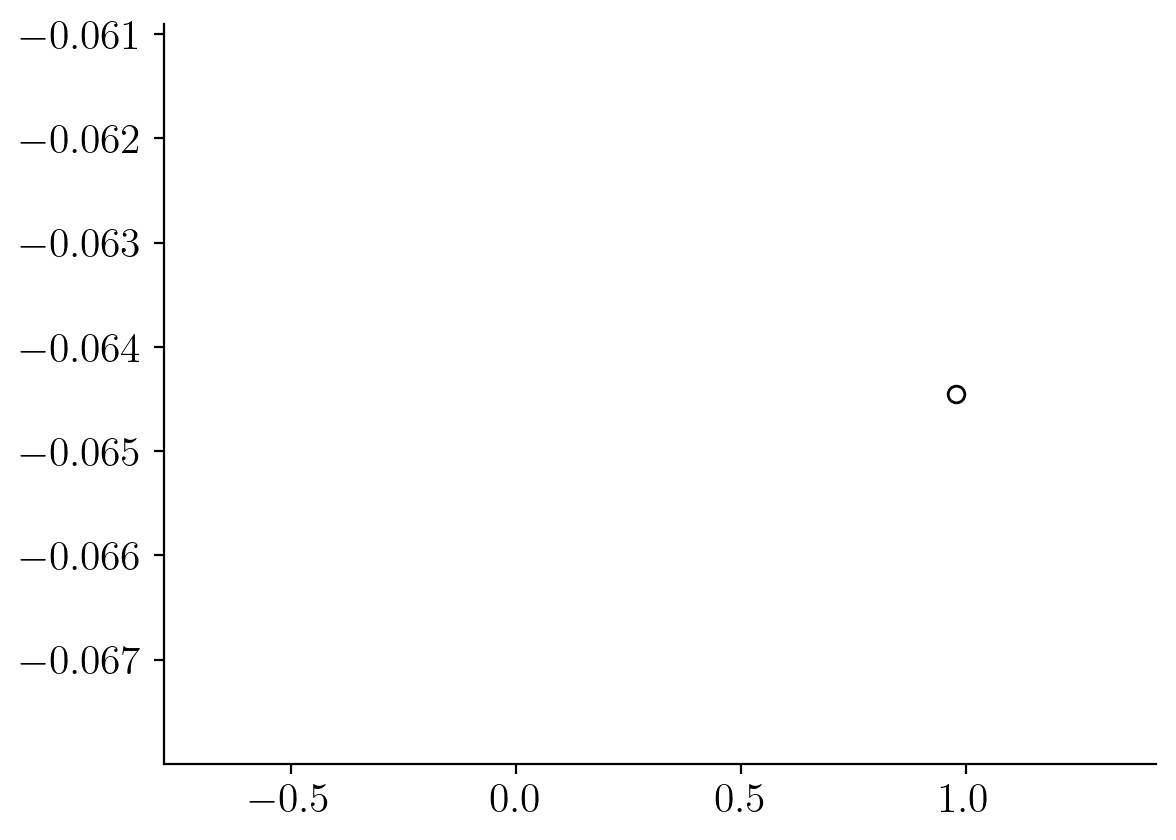

In [619]:
def animate(t, ax):
    print(t, end="\r")
    ax.cla()
    plt.scatter(*X[:t].T, c=y[:t], cmap="bone_r", edgecolor="black")
    plt.xlim(xmin, xmax)
    plt.xlim(ymin, ymax)


fig, ax = plt.subplots()
animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, n_samples))
animation.save("sequential-moons.gif", fps=20)

## Changepoints!

In [215]:
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [301]:
n_samples = 150
(X, y, rads), test = make_rotating_moons(
    n_samples, 0, n_rotations=3, noise=0.2, max_angle=300
)

In [302]:
params_init = model.init(key, X)

In [303]:
agent = BernoulliFilter(model.apply, 0.0)
bel_init = agent.init_bel(params_init)

In [304]:
def callback(bel, bel_prior, y, x):
    yhat = agent.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [305]:
bel_final, hist = agent.scan(bel_init, y, X, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [306]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)

In [307]:
Xgrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

In [308]:
Z = agent.link_fn(means[199], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
Z = np.array(Z)

In [309]:
X, y = jax.tree.map(np.array, (X, y))

In [310]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

In [311]:
(yhat.ravel() == y).mean()

Array(0.6577778, dtype=float32)

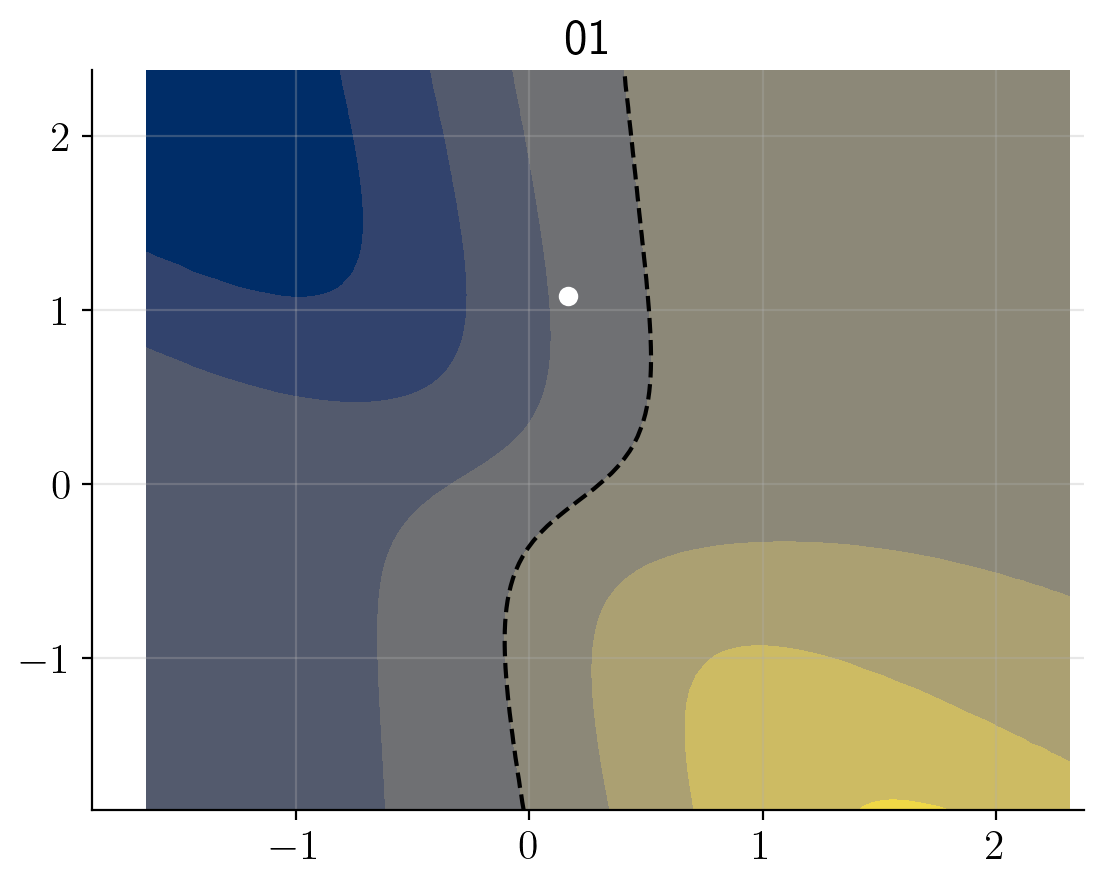

In [227]:
def animate(t, ax):
    print(t, end="\r")
    ax.cla()
    Z = agent.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)
    
    plt.contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    plt.contourf(*Xgrid, Z, cmap="cividis")
    tmin = (t // n_samples) * n_samples
    plt.scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r")
    plt.grid(alpha=0.3)
    plt.xlim(xmin, xmax)
    plt.xlim(ymin, ymax)
    plt.title(f"{t:=02}")

fig, ax = plt.subplots()
animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, len(y), 2))
animation.save("sequential-bernoulli-changepoints.gif", fps=10)

## RLPR to the rescue?

In [575]:
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [576]:
agent_base = BernoulliFilter(model.apply, 0.0)
agent = ExpfamRLPR(p_change=0.41, K=1, filter=agent_base)
bel_init = agent.init_bel(params_init, cov=1.0, log_joint_init=0.0)

In [577]:
def callback(bel, bel_prior, y, x):
    yhat = jax.vmap(agent.filter.link_fn, in_axes=(0, None))(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean,
        "runlenght": bel.runlength
    }

In [578]:
bel_final, hist = agent.scan(y[:, None], X, bel_init, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [579]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)

In [592]:
Xgrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

In [593]:
Z = agent.filter.link_fn(means[199, 0], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
Z = np.array(Z)

In [594]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

errs = (yhat.ravel() == y)
X, y, errs = jax.tree.map(np.array, (X, y, errs))
errs = pd.Series(errs) * 1.0

In [595]:
(yhat.ravel() == y).mean()

Array(0.8288889, dtype=float32)

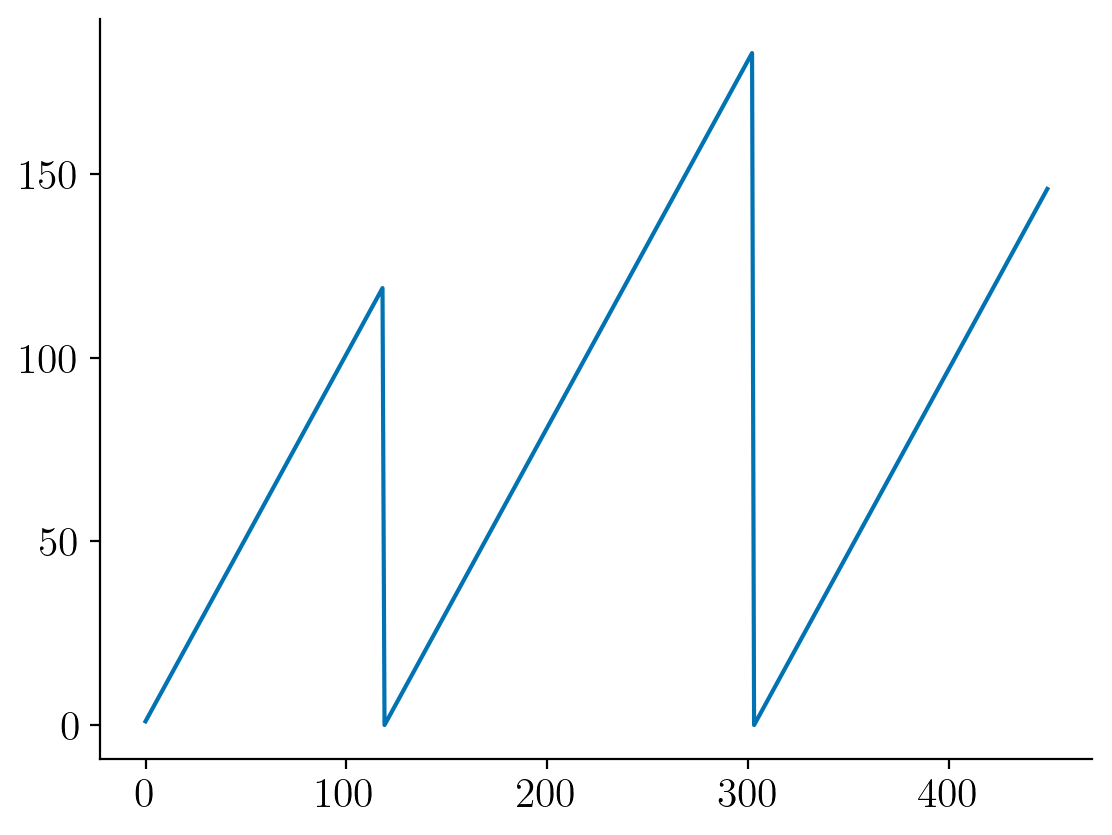

In [598]:
plt.plot(hist["runlenght"])

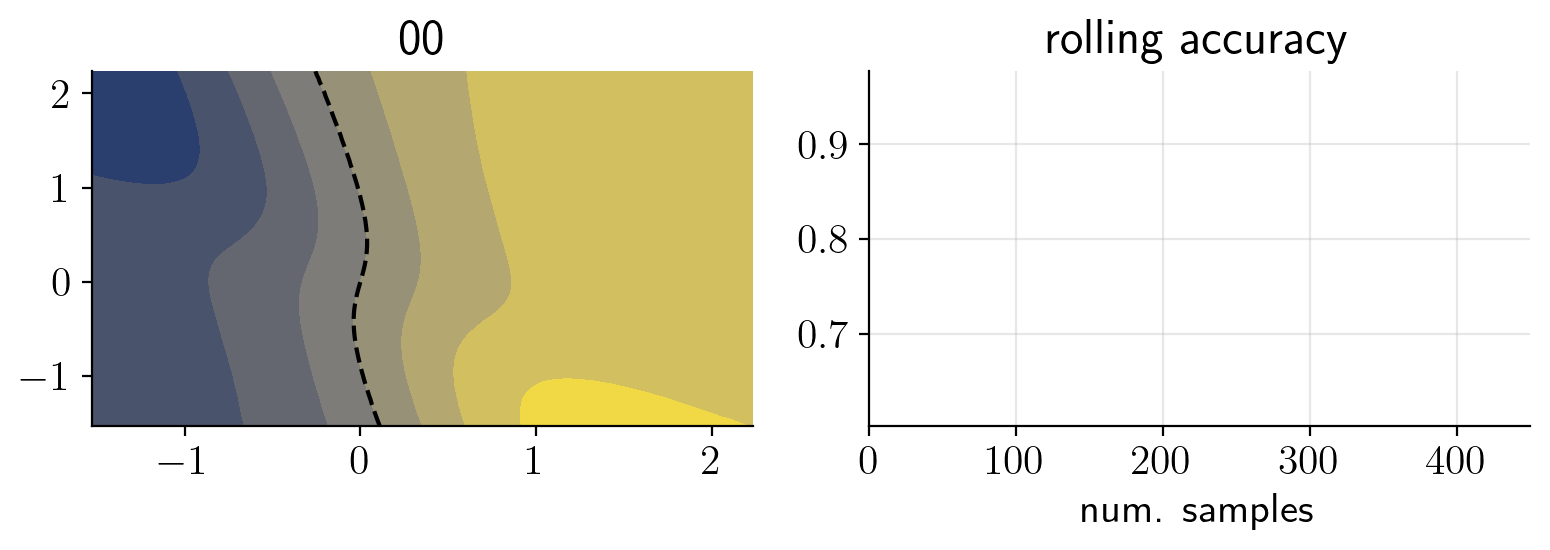

In [603]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.filter.link_fn(means[t,0], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)
    
    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap="cividis")
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_xlim(ymin, ymax)
    ax[0].set_title(f"{t:=02}")

    
    errs.rolling(np.clip(t, 1, 50)).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("rolling accuracy")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, len(y), 1))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=np.arange(len(y)))
animation.save("sequential-bernoulli-changepoints-rlpr.gif", fps=15)

## RL-OUPR

In [377]:
from rebayes_mini.methods.adaptive import ExpfamRLOUPR

In [517]:
agent_base = BernoulliFilter(model.apply, 0.0)
agent = ExpfamRLOUPR(p_change=0.01, filter=agent_base, shock=3.0, deflate_mean=True)
bel_init = agent.init_bel(params_init, cov=1.0)

In [518]:
def callback(bel, bel_prior, y, x):
    yhat = agent.filter.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean,
        "runlenght": bel.runlength,
        "posterior": bel.log_posterior,
    }

In [519]:
bel_final, hist = agent.scan(y[:, None], X, bel_init, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [520]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)

In [521]:
Xgrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

In [522]:
Z = agent.filter.link_fn(means[199], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
Z = np.array(Z)

In [539]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

errs = (yhat.ravel() == y)
X, y, errs = jax.tree.map(np.array, (X, y, errs))
errs = pd.Series(errs) * 1.0

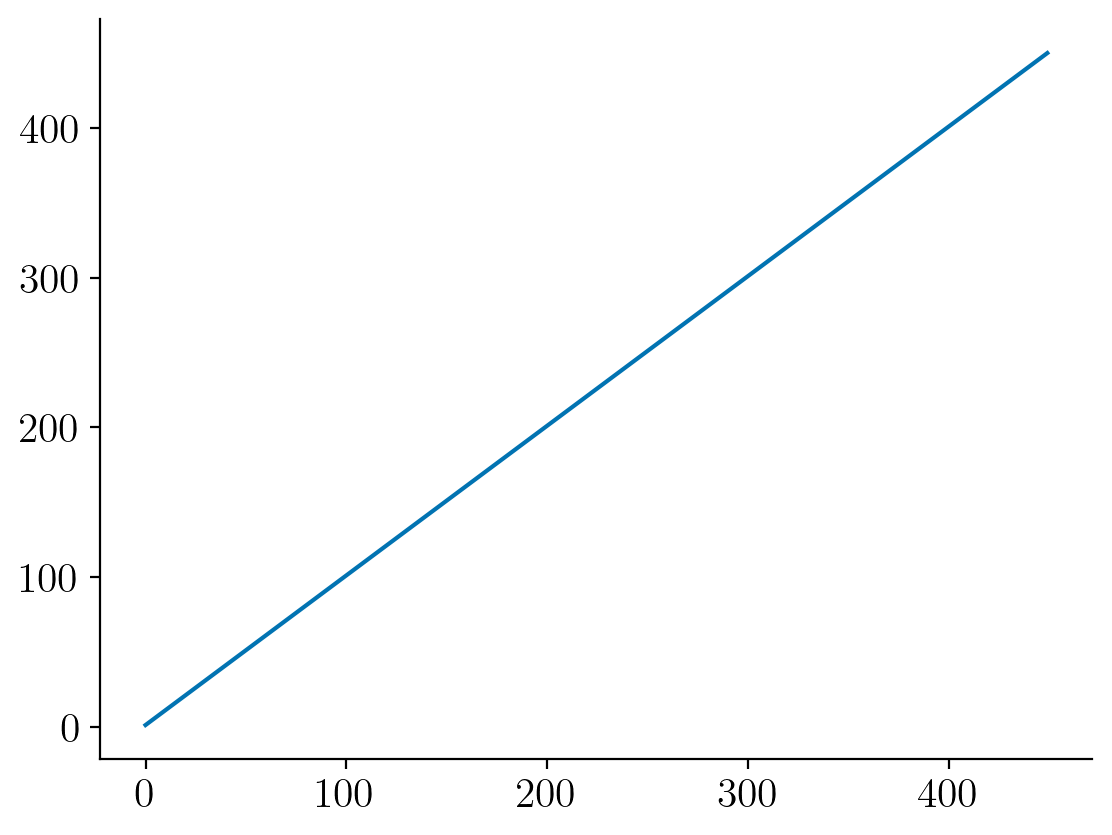

In [540]:
plt.plot(hist["runlenght"])

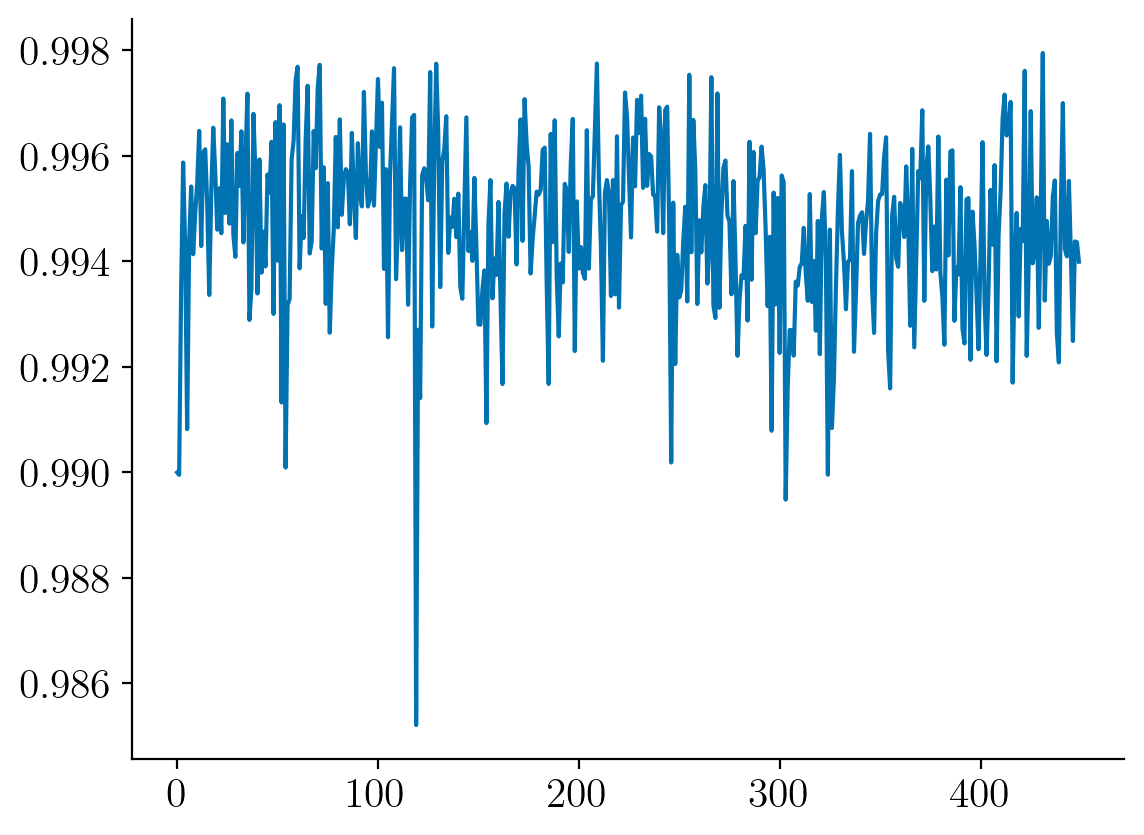

In [541]:
plt.plot(np.exp(hist['posterior']))

In [ ]:
a

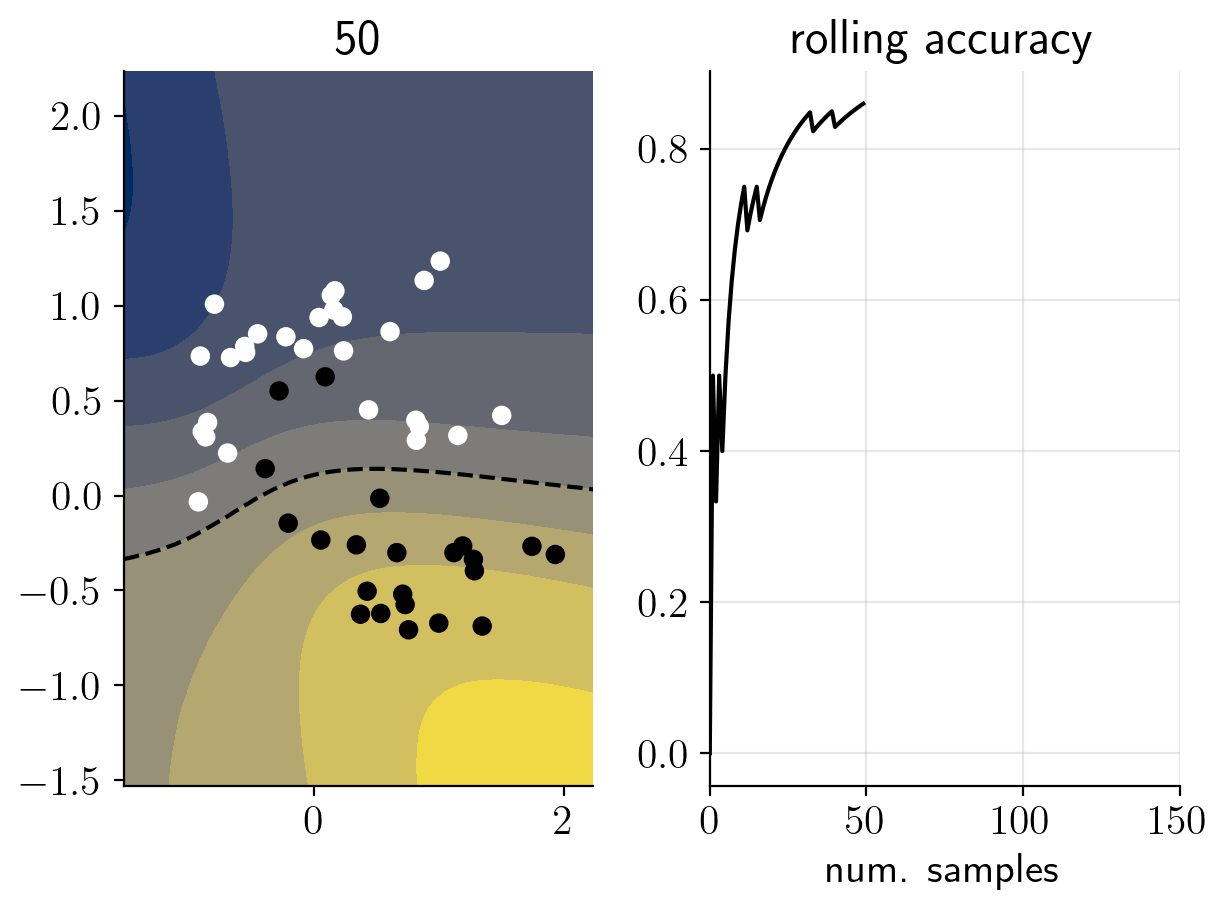

In [563]:
fig, ax = plt.subplots(1, 2)
animate(50, ax)

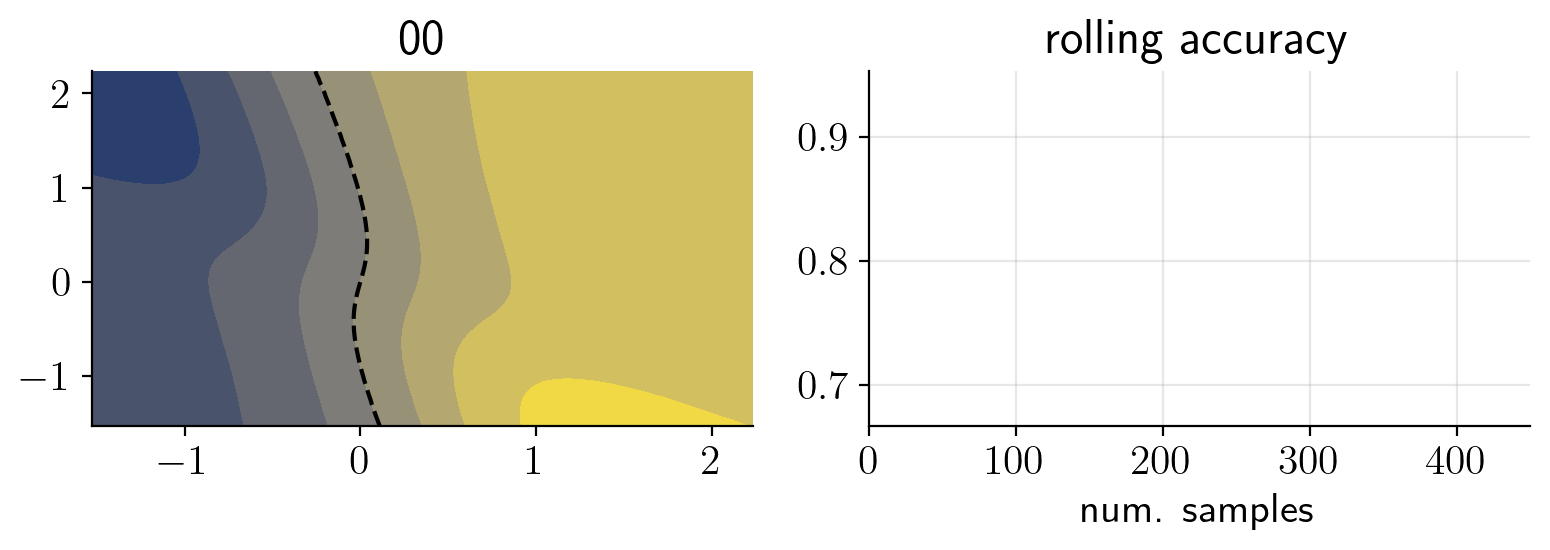

In [574]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.filter.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap="cividis")
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_xlim(ymin, ymax)
    ax[0].set_title(f"{t:=02}")

    
    errs.rolling(min(50, t)).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("rolling accuracy")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, len(y), 1))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=np.arange(len(y)))
animation.save("sequential-bernoulli-changepoints-rloupr.gif", fps=15)